# Projection of movies onto a vector

I was inspired by Prof. Hennig's plots on the sea ice extent, especially the one on standard deviation (the one with the tweet).

He analyzes the sea ice extent (scalar) over time, managing to analyze the standard deviation, the mean, its yearly normal distribution.

As such, I wanted to do the same with our movies dataset but we are using embeddings. As such, we cannot just simply calculate standard deviation and mean of text embeddings. They wouldn't make sense. We have to find a metric which can be calculated from the movie embeddings.

This is idea 1 of 2, which is to find an arbitrary vector that is in the embedding space and project the movie embeddings onto this vector. Based on the choice of this vector, we will be able to see how much of each movie embedding lies on the vector, and we can then do temporal analysis to see how this metric evolves over time. 

Choices of the arbitrary vector:
1. PC1. PCA takes care of the choice of the vector and gives the most important merge of all embedding dimensions. However, we have experimented with PCA before and the explained variance of PC1 is only around 3%. Hence this is *DOGSHIT*.
2. Difference between embeddings of 1930's centroid and 2025's centroid. This should in theory capture the direction of evolution of movies over the years. Here centroid means arithmetic mean and not **medoid** which is a movie which actually exists in the dataset. 
3. Vector between genre centroids. We can see then how movies evolve from genre to genre. However this means we must choose 2 genres and it will be hard to compare all genres at one go.

# Imports and data loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.data_utils import *

In [2]:
data_path = os.path.join(base_path, "data", "data_final")
csv_path = os.path.join(data_path, "final_dataset.csv")

In [3]:
df = load_final_data_with_embeddings(csv_path, data_path, verbose=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       92374 non-null  object 
 1   country                        91534 non-null  object 
 2   imdb_id                        91006 non-null  object 
 3   duration                       57734 non-null  float64
 4   duration_all                   57734 non-null  object 
 5   actors_id                      75496 non-null  object 
 6   actors                         75496 non-null  object 
 7   directors_id                   86598 non-null  object 
 8   directors                      86598 non-null  object 
 9   genre_id                       80918 non-null  object 
 10  genre                          80884 non-null  object 
 11  release_date                   92374 non-null  object 
 12  wikidata_class                 92374 non-null 

In [5]:
df = df.filter([
    "movie_id", 
    "plot",
    "year",
    "embedding",
    "genre",
    "new_genre",
])

In [6]:
# Label the new genres
with open("../cluster_to_genre_mapping_01122025.json", "r") as f:
    genre_fix_mapping = json.load(f)

df = df[(df["new_genre"] != "Unknown") & (df["new_genre"].notna())].reset_index(drop=True)
df["new_genre"] = df["new_genre"].apply(lambda x: [genre_fix_mapping[i] for i in x.split("|")])

In [7]:
df.shape

(79984, 6)

In [8]:
df.head()

,movie_id,plot,year,embedding,genre,new_genre
0,Q158047,Immanuel Rath is a professor at the local Gymn...,1930,"[-0.04922, 0.0475, 0.003048, -0.011536, -0.020...","drama film, film based on literature",[drama]
1,Q166089,The first act of the film covers Lincoln's ear...,1930,"[-0.012054, 0.0181, -0.04782, 0.01465, -0.0224...","drama film, war film, biographical film, histo...","[drama, family youth and war, biographical]"
2,Q185214,"Chris Christofferson (George F. Marion), the a...",1930,"[-0.01281, -0.011314, -0.04633, -0.001071, -0....","drama film, romance film","[drama, romance]"
3,Q272599,Early in World War I Professor Kantorek gives ...,1930,"[-0.01184, 0.0401, -0.03577, -0.002903, 0.0011...","drama film, war film, film based on a novel","[drama, family youth and war]"
4,Q531332,"Kent (Robert Montgomery), a drunk driver who c...",1930,"[-0.01392, -0.003054, -0.00642, -0.01338, -0.0...","drama film, prison film, crime film, romance film","[crime and thriller, drama, romance, action cr..."


# Vector choice 1: Centroid of years

In [9]:
first_year_centroid = np.stack(df[df.year==1930].sample(n=300).embedding.values).mean(axis=0)
last_year_centroid = np.stack(df[df.year==2024].sample(n=300).embedding.values).mean(axis=0)
vector1 = last_year_centroid - first_year_centroid

In [10]:
vector1.min(), vector1.max()

(np.float16(-0.02028), np.float16(0.02328))

In [11]:
df["proj_vec1"] = df["embedding"].apply(lambda x: float(x@vector1))

In [12]:
df.proj_vec1.min(), df.proj_vec1.max()

(np.float64(-0.07073974609375), np.float64(0.050567626953125))

Text(0, 0.5, 'Dot product')

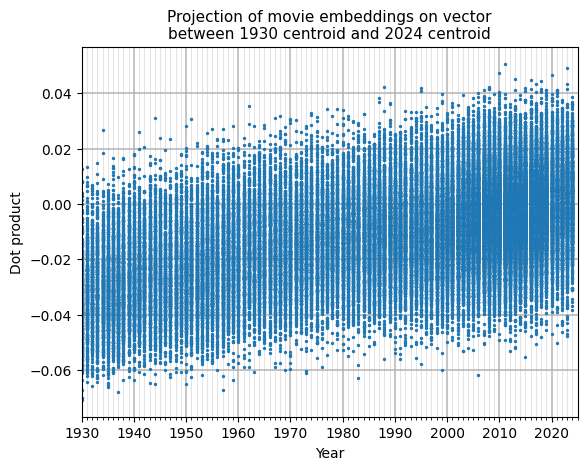

In [13]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots()
ax.scatter(df.year, df.proj_vec1, s=2)
ax.set_xlim(1930, 2025)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_axisbelow(True)
ax.grid(which="major", linewidth=1.3, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_title("Projection of movie embeddings on vector\nbetween 1930 centroid and 2024 centroid", fontsize=11)
ax.set_xlabel("Year")
ax.set_ylabel("Dot product")

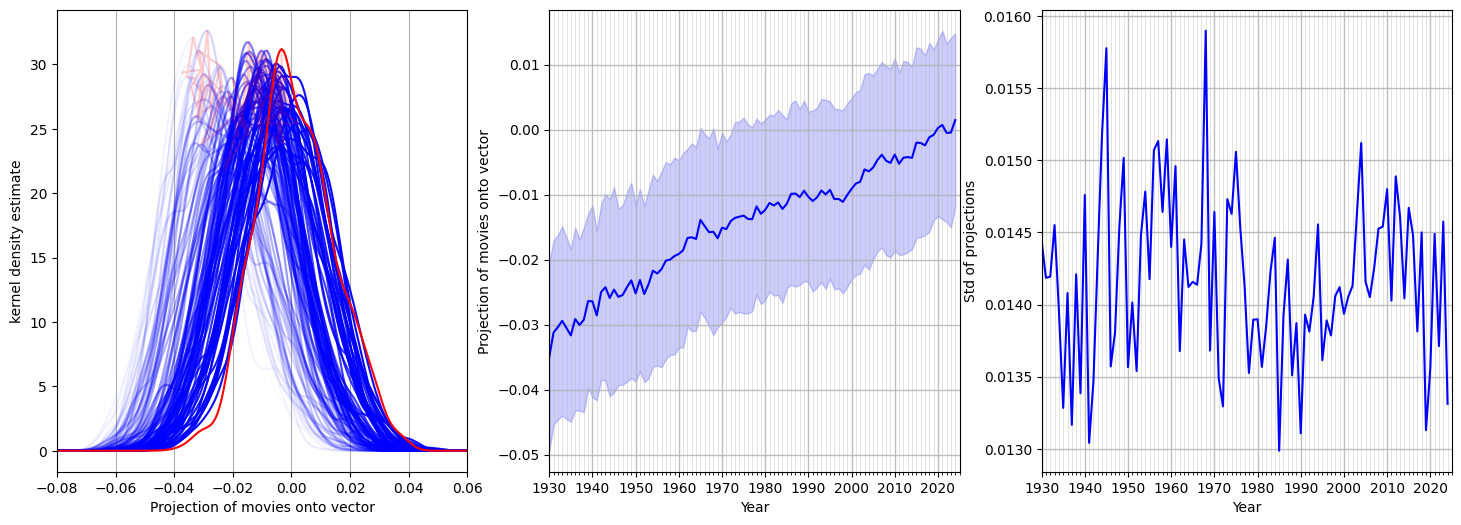

In [14]:
from scipy import stats

fig, axs = plt.subplots(1, 3, figsize=(18,6))
projections = []
years = []
peak_xs = []
peak_ys = []
for year in np.arange(1930, 2025):
    year_data = df[df["year"] == year]
    projection = year_data["proj_vec1"].sample(n=1000, replace=True)
    # hist = np.histogram(anomaly, bins=30, range=(-3,3), density=True)
    kde = stats.gaussian_kde(projection)

    # axs[0].plot(hist[1][:-1], hist[0], color=rgb.tue_blue, alpha=(year - 1980) / (2023 - 1980))
    xp = np.linspace(-0.08, 0.06, 200)

    if year == 2024:
        color = "red"
    # elif year > 2023:
    #     color = rgb.tue_orange
    # else:
    #     color = rgb.tue_blue
    else:
        color = "blue"

    kde_values = kde.pdf(xp)
    peak_x = xp[np.argmax(kde_values)]
    peak_y = np.max(kde_values)
    peak_xs.append(peak_x)
    peak_ys.append(peak_y)

    axs[0].plot(xp, kde_values, color=color, alpha=(year - 1930) / (2025 - 1930))
    # Plot the peak as a point
    # axs[0].scatter(peak_x, peak_y, color="red", s=20, alpha=(year - 1930) / (2025 - 1930))  # s=marker size
    # axs[0].fill_between(xp, kde.pdf(xp), color=rgb.tue_blue, alpha=(year - 1980) / (2023 - 1980))
    projections.append(projection)
    years.append(year)

axs[0].plot(peak_xs, peak_ys, color="red", alpha=0.2)

means = np.array([np.mean(p) for p in projections])
stds = np.array([np.std(p) for p in projections])
years = np.array(years)  # your list of years

# Plot mean line
axs[1].plot(years, means, color="blue", label='Mean')

# Fill between mean - std and mean + std
axs[1].fill_between(
    years, 
    means - stds, 
    means + stds, 
    color="blue", 
    alpha=0.2  # adjust transparency
)

axs[0].set_xlabel("Projection of movies onto vector")
axs[0].set_ylabel("kernel density estimate")
axs[0].set_xlim([-0.08, 0.06])
axs[0].grid(which="major", axis="x")

axs[1].set_xlabel("Year")
axs[1].set_ylabel("Projection of movies onto vector")
axs[1].xaxis.set_major_locator(plt.MultipleLocator(10))
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[1].grid(which="major", linewidth=1, alpha=0.8)
axs[1].grid(which="minor", linewidth=0.5, alpha=0.5)
axs[1].set_xlim([1930, 2025])

axs[2].plot(years, stds, color="blue", label="Standard deviation")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Std of projections")
axs[2].xaxis.set_major_locator(plt.MultipleLocator(10))
axs[2].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[2].grid(which="major", linewidth=1, alpha=0.8)
axs[2].grid(which="minor", linewidth=0.5, alpha=0.5)
axs[2].set_xlim([1930, 2025])

# axs[1].axvspan(1981, 2010, color=rgb.tue_gray, alpha=0.5)
# axs[1].text(
#     1995.5,
#     -2.0,
#     "reference period (1981-2010)",
#     color=rgb.tue_dark,
#     fontsize=8,
#     ha="center",
#     va="center",
#     rotation=0,
# )
# axs[1].axhline(0, color="black", linewidth=0.5)

# plt.savefig("anomaly_distribution.pdf")
plt.show();

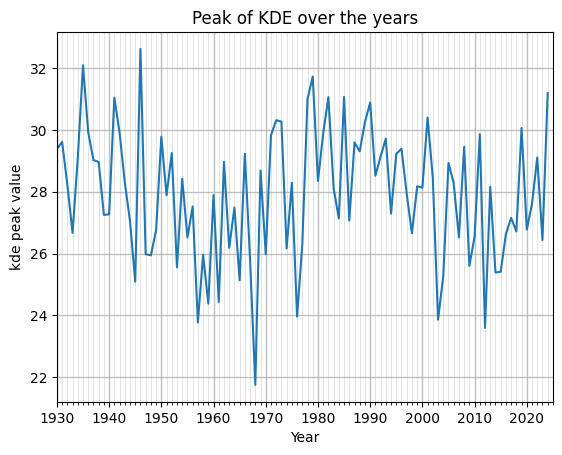

In [15]:
fig, axs = plt.subplots()
axs.plot(years, peak_ys)
axs.set_title("Peak of KDE over the years")
axs.set_xlabel("Year")
axs.set_ylabel("kde peak value")
axs.xaxis.set_major_locator(plt.MultipleLocator(10))
axs.xaxis.set_minor_locator(plt.MultipleLocator(1))
axs.grid(which="major", linewidth=1, alpha=0.8)
axs.grid(which="minor", linewidth=0.5, alpha=0.5)
axs.set_xlim([1930, 2025])
plt.show();

Plots analysis:
1. KDE plots are shifting in mean (not important because it tells us "movies are getting newer")
2. More importantly the standard deviations spike during 1940s to 1970s.
    * This could be due to the "Golden age of Hollywood" where studios controlled everything
3. Standard deviations of how movies move along from 1930 to 2025 drops after 1980s onwards and becomes constant
    * There is a diversity plateau.
    * Might show the BlockBuster hypothesis where movies just stay constant around blockbusters.

More analysis to be conducted:
* Analyze the tails using [Kurtosis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html)
* `residual = Projection_value - mean_projection (for a year)`
* Residuals can tell us how "advanced" or "retro" a movie is when compared to other projections

In [16]:
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df[df.year<=1940], row="year", hue="year", aspect=10, height=1, palette=pal)

# g.map(sns.kdeplot, "proj_vec1", clip_on=False, fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "proj_vec1", clip_on=False, color="w", lw=2, )
# # g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# for ax in g.axes.flat:
#     ax.axhline(0, linewidth=2, color='k', clip_on=False)

# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, 0.5, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)
    
# # g.map(label, "year")
# g.figure.subplots_adjust(hspace=-0.5)
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# plt.show()

# Cant get this plot to work well. Reference https://seaborn.pydata.org/examples/kde_ridgeplot

## Kurtosis analysis

Kurtosis is the fourth central moment divided by the square of the variance. If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution.

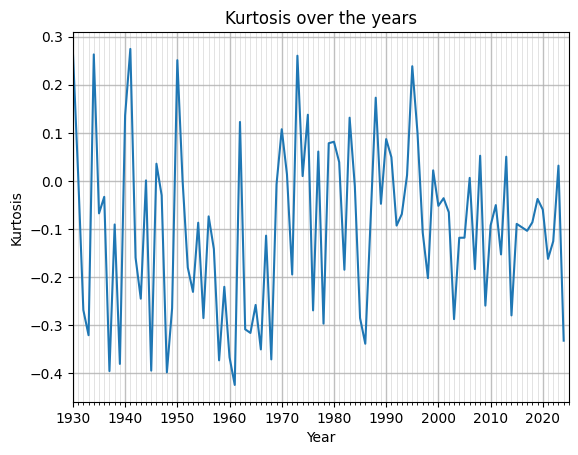

In [17]:
years = np.arange(df.year.min(), df.year.max() + 1)
kurtosis = []
for year in years:
    year_df = df[df.year==year]
    year_kurtosis_value = stats.kurtosis(year_df.proj_vec1.tolist())
    kurtosis.append(year_kurtosis_value)

fig, axs = plt.subplots()
axs.plot(years, kurtosis)
axs.set_title("Kurtosis over the years")
axs.set_xlabel("Year")
axs.set_ylabel("Kurtosis")
axs.xaxis.set_major_locator(plt.MultipleLocator(10))
axs.xaxis.set_minor_locator(plt.MultipleLocator(1))
axs.grid(which="major", linewidth=1, alpha=0.8)
axs.grid(which="minor", linewidth=0.5, alpha=0.5)
axs.set_xlim([1930, 2025])
plt.show();


# Vector choice 2: Overall movie embedding toward action genre

In [18]:
df["genre"] = df["genre"].apply(lambda x: x.split(", "))

In [19]:
unique_genres = list(set([x
    for xs in df.genre.tolist()
    for x in xs]))

In [20]:
"action film" in unique_genres

True

In [21]:
overall_mean_embedding = np.stack(df[(df.genre.apply(lambda x: "action film" in x)) & (df.year==1930)].embedding.values).mean(axis=0)

In [22]:
overall_mean_embedding

array([-0.02167 ,  0.01114 , -0.03357 , ..., -0.01048 , -0.005234,
        0.002466], shape=(1024,), dtype=float16)

In [23]:
action_mean_embedding = np.stack(df[(df.genre.apply(lambda x: "action film" in x)) & (df.year==2024)].embedding.values).mean(axis=0)

In [24]:
vec2 = action_mean_embedding - overall_mean_embedding

In [25]:
df["proj_vec2"] = df["embedding"].apply(lambda x: x@vec2)

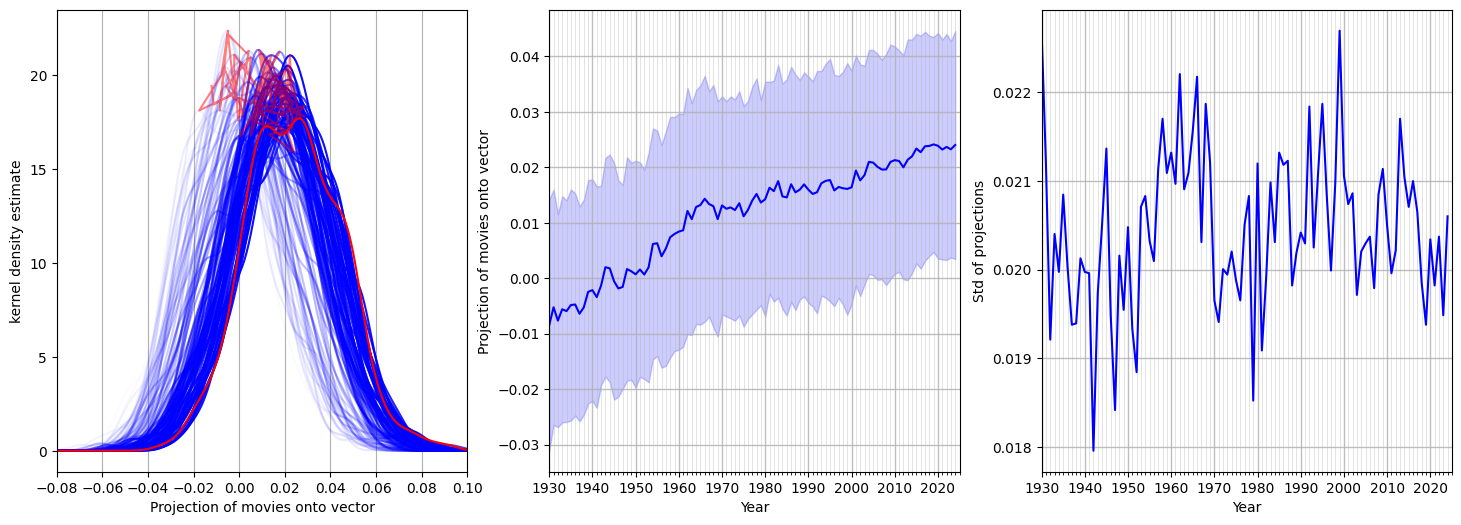

In [26]:
from scipy import stats

fig, axs = plt.subplots(1, 3, figsize=(18,6))
projections = []
years = []
peak_xs = []
peak_ys = []
for year in np.arange(1930, 2025):
    year_data = df[df["year"] == year]
    projection = year_data["proj_vec2"].sample(n=1000, replace=True)
    # hist = np.histogram(anomaly, bins=30, range=(-3,3), density=True)
    kde = stats.gaussian_kde(projection)

    # axs[0].plot(hist[1][:-1], hist[0], color=rgb.tue_blue, alpha=(year - 1980) / (2023 - 1980))
    xp = np.linspace(-0.08, 0.10, 200)

    if year == 2024:
        color = "red"
    # elif year > 2023:
    #     color = rgb.tue_orange
    # else:
    #     color = rgb.tue_blue
    else:
        color = "blue"

    kde_values = kde.pdf(xp)
    peak_x = xp[np.argmax(kde_values)]
    peak_y = np.max(kde_values)
    peak_xs.append(peak_x)
    peak_ys.append(peak_y)

    axs[0].plot(xp, kde_values, color=color, alpha=(year - 1930) / (2025 - 1930))
    # Plot the peak as a point
    # axs[0].scatter(peak_x, peak_y, color="red", s=20, alpha=(year - 1930) / (2025 - 1930))  # s=marker size
    # axs[0].fill_between(xp, kde.pdf(xp), color=rgb.tue_blue, alpha=(year - 1980) / (2023 - 1980))
    projections.append(projection)
    years.append(year)

axs[0].plot(peak_xs, peak_ys, color="red", alpha=0.5)

means = np.array([np.mean(p) for p in projections])
stds = np.array([np.std(p) for p in projections])
years = np.array(years)  # your list of years

# Plot mean line
axs[1].plot(years, means, color="blue", label='Mean')

# Fill between mean - std and mean + std
axs[1].fill_between(
    years, 
    means - stds, 
    means + stds, 
    color="blue", 
    alpha=0.2  # adjust transparency
)

axs[0].set_xlabel("Projection of movies onto vector")
axs[0].set_ylabel("kernel density estimate")
axs[0].set_xlim([-0.08, 0.10])
axs[0].grid(which="major", axis="x")

axs[1].set_xlabel("Year")
axs[1].set_ylabel("Projection of movies onto vector")
axs[1].xaxis.set_major_locator(plt.MultipleLocator(10))
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[1].grid(which="major", linewidth=1, alpha=0.8)
axs[1].grid(which="minor", linewidth=0.5, alpha=0.5)
axs[1].set_xlim([1930, 2025])

axs[2].plot(years, stds, color="blue", label="Standard deviation")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Std of projections")
axs[2].xaxis.set_major_locator(plt.MultipleLocator(10))
axs[2].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[2].grid(which="major", linewidth=1, alpha=0.8)
axs[2].grid(which="minor", linewidth=0.5, alpha=0.5)
axs[2].set_xlim([1930, 2025])

# axs[1].axvspan(1981, 2010, color=rgb.tue_gray, alpha=0.5)
# axs[1].text(
#     1995.5,
#     -2.0,
#     "reference period (1981-2010)",
#     color=rgb.tue_dark,
#     fontsize=8,
#     ha="center",
#     va="center",
#     rotation=0,
# )
# axs[1].axhline(0, color="black", linewidth=0.5)

# plt.savefig("anomaly_distribution.pdf")
plt.show();

In [27]:
"romance film" in unique_genres

True

In [28]:
romance_embedding_start = np.stack(df[(df.genre.apply(lambda x: "romance film" in x)) & (df.year==1930)].embedding.values).mean(axis=0)

In [29]:
romance_embedding_end = np.stack(df[(df.genre.apply(lambda x: "romance film" in x)) & (df.year==2024)].embedding.values).mean(axis=0)

In [30]:
vec3 = romance_embedding_end - romance_embedding_start

In [31]:
df["proj_vec3"] = df["embedding"].apply(lambda x: x@vec3)

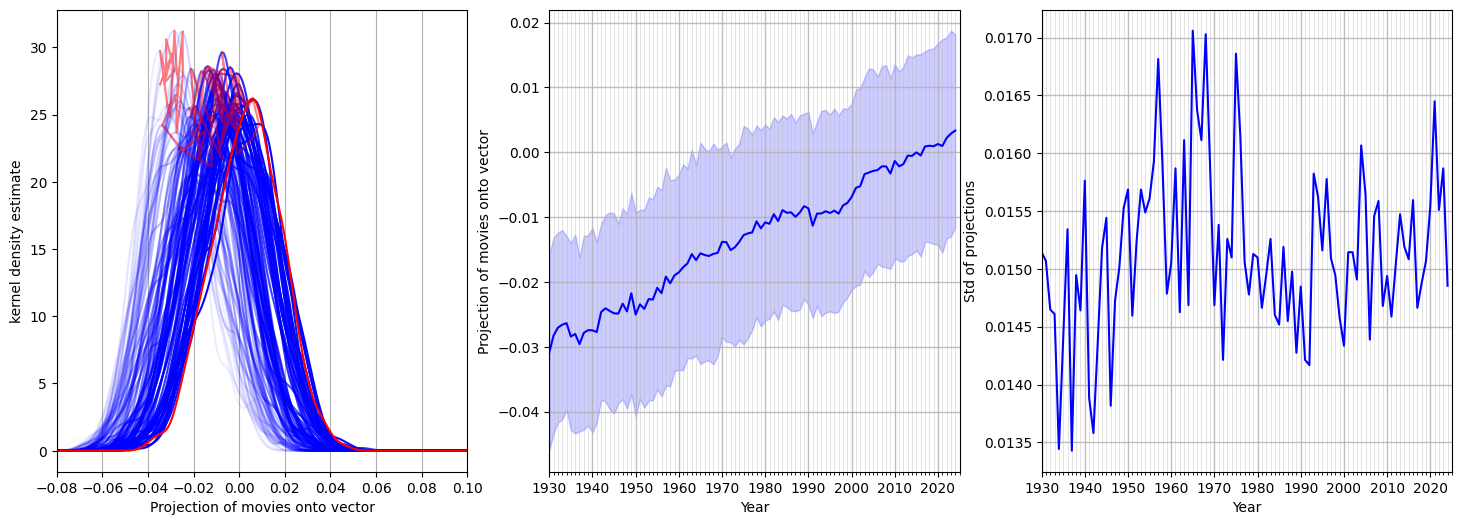

In [32]:
from scipy import stats

fig, axs = plt.subplots(1, 3, figsize=(18,6))
projections = []
years = []
peak_xs = []
peak_ys = []
for year in np.arange(1930, 2025):
    year_data = df[df["year"] == year]
    projection = year_data["proj_vec3"].sample(n=1000, replace=True)
    # hist = np.histogram(anomaly, bins=30, range=(-3,3), density=True)
    kde = stats.gaussian_kde(projection)

    # axs[0].plot(hist[1][:-1], hist[0], color=rgb.tue_blue, alpha=(year - 1980) / (2023 - 1980))
    xp = np.linspace(-0.08, 0.10, 200)

    if year == 2024:
        color = "red"
    # elif year > 2023:
    #     color = rgb.tue_orange
    # else:
    #     color = rgb.tue_blue
    else:
        color = "blue"

    kde_values = kde.pdf(xp)
    peak_x = xp[np.argmax(kde_values)]
    peak_y = np.max(kde_values)
    peak_xs.append(peak_x)
    peak_ys.append(peak_y)

    axs[0].plot(xp, kde_values, color=color, alpha=(year - 1930) / (2025 - 1930))
    # Plot the peak as a point
    # axs[0].scatter(peak_x, peak_y, color="red", s=20, alpha=(year - 1930) / (2025 - 1930))  # s=marker size
    # axs[0].fill_between(xp, kde.pdf(xp), color=rgb.tue_blue, alpha=(year - 1980) / (2023 - 1980))
    projections.append(projection)
    years.append(year)

axs[0].plot(peak_xs, peak_ys, color="red", alpha=0.5)

means = np.array([np.mean(p) for p in projections])
stds = np.array([np.std(p) for p in projections])
years = np.array(years)  # your list of years

# Plot mean line
axs[1].plot(years, means, color="blue", label='Mean')

# Fill between mean - std and mean + std
axs[1].fill_between(
    years, 
    means - stds, 
    means + stds, 
    color="blue", 
    alpha=0.2  # adjust transparency
)

axs[0].set_xlabel("Projection of movies onto vector")
axs[0].set_ylabel("kernel density estimate")
axs[0].set_xlim([-0.08, 0.10])
axs[0].grid(which="major", axis="x")

axs[1].set_xlabel("Year")
axs[1].set_ylabel("Projection of movies onto vector")
axs[1].xaxis.set_major_locator(plt.MultipleLocator(10))
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[1].grid(which="major", linewidth=1, alpha=0.8)
axs[1].grid(which="minor", linewidth=0.5, alpha=0.5)
axs[1].set_xlim([1930, 2025])

axs[2].plot(years, stds, color="blue", label="Standard deviation")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Std of projections")
axs[2].xaxis.set_major_locator(plt.MultipleLocator(10))
axs[2].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[2].grid(which="major", linewidth=1, alpha=0.8)
axs[2].grid(which="minor", linewidth=0.5, alpha=0.5)
axs[2].set_xlim([1930, 2025])

# axs[1].axvspan(1981, 2010, color=rgb.tue_gray, alpha=0.5)
# axs[1].text(
#     1995.5,
#     -2.0,
#     "reference period (1981-2010)",
#     color=rgb.tue_dark,
#     fontsize=8,
#     ha="center",
#     va="center",
#     rotation=0,
# )
# axs[1].axhline(0, color="black", linewidth=0.5)

# plt.savefig("anomaly_distribution.pdf")
plt.show();

# Action movie over time

In [10]:
unique_new_genres = list(set([x
    for xs in df.new_genre.tolist()
    for x in xs]))

In [11]:
unique_new_genres

['adventure music and diverse',
 'family youth and war',
 'horror and scifi',
 'action crime and exploitation',
 'adventure and fantasy',
 'romance',
 'documentary experimental and film history',
 'film noir',
 'anime',
 'documentary animation and educational',
 'action western and international',
 'drama',
 'musical',
 'biographical',
 'crime and thriller',
 'japanese media',
 'fantasy and scifi',
 'comedy',
 'satire and dark comedy']

In [19]:
years = np.arange(df.year.min(), df.year.max() + 1)

In [20]:
action_from_centroid = []
overall_mean_embedding = np.stack(df.embedding.values).mean(axis=0)
for year in years:
    year_action_df = df[(df.year==year) & (df.new_genre.apply(lambda x: "action" in str(x)))].sample(n=26)
    year_action_centroid = np.stack(year_action_df.embedding.values).mean(axis=0)
    # Cosine distance between overall_mean_embedding and year_action_centroid
    cos_distance = 1 - (overall_mean_embedding @ year_action_centroid) / (np.linalg.norm(overall_mean_embedding) * np.linalg.norm(year_action_centroid))
    action_from_centroid.append(cos_distance)

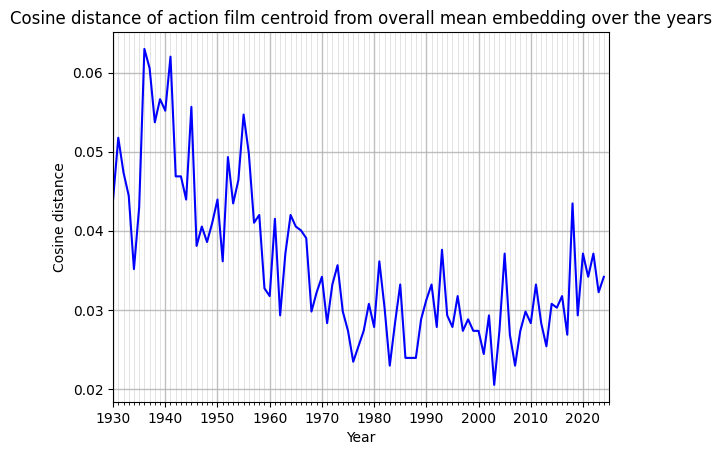

In [21]:
# Plot the action_from_centroid over the years
fig, axs = plt.subplots()
axs.plot(years, action_from_centroid, color="blue")
axs.set_title("Cosine distance of action film centroid from overall mean embedding over the years")
axs.set_xlabel("Year")
axs.set_ylabel("Cosine distance")
axs.xaxis.set_major_locator(plt.MultipleLocator(10))
axs.xaxis.set_minor_locator(plt.MultipleLocator(1))
axs.grid(which="major", linewidth=1, alpha=0.8)
axs.grid(which="minor", linewidth=0.5, alpha=0.5)
axs.set_xlim([1930, 2025])
plt.show();

In [35]:
import numpy as np

action_from_centroid = []
hoeffding_lower = []
hoeffding_upper = []
quantile_lower = []
quantile_upper = []
overall_mean_embedding = np.stack(df.embedding.values).mean(axis=0)

alpha = 0.05  # For 95% confidence
n_sample = 1000  # Sample size
n_bootstrap = 1000  # Number of bootstrap iterations for point estimate

for year in years:
    year_action_df = df[(df.year==year) & (df.genre.apply(lambda x: "action film" in x))]
    
    # Collect bootstrap samples to estimate mean
    bootstrap_distances = []
    for _ in range(n_bootstrap):
        bootstrap_sample = year_action_df.sample(n=min(n_sample, len(year_action_df)), replace=True)
        year_action_centroid = np.stack(bootstrap_sample.embedding.values).mean(axis=0)
        cos_distance = 1 - (overall_mean_embedding @ year_action_centroid) / (np.linalg.norm(overall_mean_embedding) * np.linalg.norm(year_action_centroid))
        bootstrap_distances.append(cos_distance)
    
    mean_distance = np.mean(bootstrap_distances)
    
    # Hoeffding's bound with correct range [0, 1]
    a, b = 0, 1  # Range of cosine distance in practice
    epsilon = np.sqrt(-np.log(alpha/2) * (b - a)**2 / (2 * n_sample))
    
    action_from_centroid.append(mean_distance)
    hoeffding_lower.append(max(0, mean_distance - epsilon))
    hoeffding_upper.append(min(1, mean_distance + epsilon))
    quantile_upper.append(np.percentile(bootstrap_distances, (1 - (1-alpha)) / 2 * 100))
    quantile_lower.append(np.percentile(bootstrap_distances, (1 + (1-alpha)) / 2 * 100))

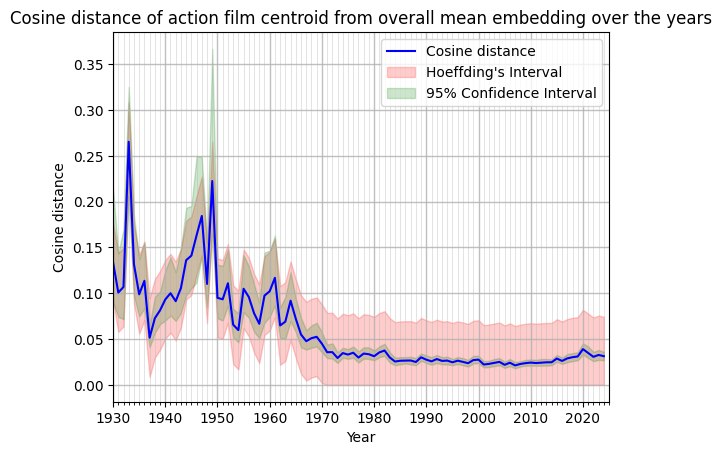

In [36]:
# Plot cos_distance over the years with error bounds filled
fig, axs = plt.subplots()
axs.plot(years, action_from_centroid, label="Cosine distance", color="blue")
axs.fill_between(years, hoeffding_lower, hoeffding_upper, color="red", alpha=0.2, label="Hoeffding's Interval")
axs.fill_between(years, quantile_lower, quantile_upper, color="green", alpha=0.2, label="95% Confidence Interval")
axs.set_title("Cosine distance of action film centroid from overall mean embedding over the years")
axs.set_xlabel("Year")
axs.set_ylabel("Cosine distance")
axs.xaxis.set_major_locator(plt.MultipleLocator(10))
axs.xaxis.set_minor_locator(plt.MultipleLocator(1))
axs.grid(which="major", linewidth=1, alpha=0.8)
axs.grid(which="minor", linewidth=0.5, alpha=0.5)
axs.set_xlim([1930, 2025])
axs.legend()
plt.show();

In [37]:
import numpy as np

romance_from_centroid = []
hoeffding_lower = []
hoeffding_upper = []
quantile_lower = []
quantile_upper = []
overall_mean_embedding = np.stack(df.embedding.values).mean(axis=0)

alpha = 0.05  # For 95% confidence
n_sample = 1000  # Sample size
n_bootstrap = 1000  # Number of bootstrap iterations for point estimate

for year in years:
    year_romance_df = df[(df.year==year) & (df.genre.apply(lambda x: "romance film" in x))]
    
    # Collect bootstrap samples to estimate mean
    bootstrap_distances = []
    for _ in range(n_bootstrap):
        bootstrap_sample = year_romance_df.sample(n=min(n_sample, len(year_romance_df)), replace=True)
        year_romance_centroid = np.stack(bootstrap_sample.embedding.values).mean(axis=0)
        cos_distance = 1 - (overall_mean_embedding @ year_romance_centroid) / (np.linalg.norm(overall_mean_embedding) * np.linalg.norm(year_romance_centroid))
        bootstrap_distances.append(cos_distance)
    
    mean_distance = np.mean(bootstrap_distances)
    
    # Hoeffding's bound with correct range [0, 1]
    a, b = 0, 1  # Range of cosine distance in practice
    epsilon = np.sqrt(-np.log(alpha/2) * (b - a)**2 / (2 * n_sample))
    
    romance_from_centroid.append(mean_distance)
    hoeffding_lower.append(max(0, mean_distance - epsilon))
    hoeffding_upper.append(min(1, mean_distance + epsilon))
    quantile_upper.append(np.percentile(bootstrap_distances, (1 - (1-alpha)) / 2 * 100))
    quantile_lower.append(np.percentile(bootstrap_distances, (1 + (1-alpha)) / 2 * 100))

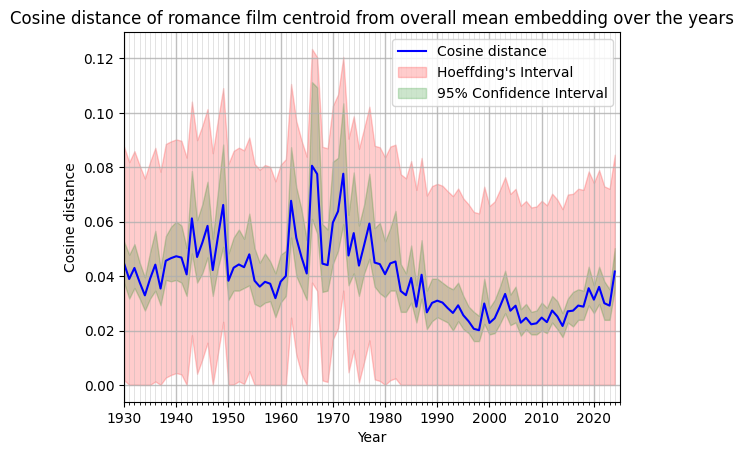

In [38]:
# Plot the romance_from_centroid over the years
fig, axs = plt.subplots()
axs.plot(years, romance_from_centroid, label="Cosine distance", color="blue")
axs.fill_between(years, hoeffding_lower, hoeffding_upper, color="red", alpha=0.2, label="Hoeffding's Interval")
axs.fill_between(years, quantile_lower, quantile_upper, color="green", alpha=0.2, label="95% Confidence Interval")
axs.set_title("Cosine distance of romance film centroid from overall mean embedding over the years")
axs.set_xlabel("Year")
axs.set_ylabel("Cosine distance")
axs.xaxis.set_major_locator(plt.MultipleLocator(10))
axs.xaxis.set_minor_locator(plt.MultipleLocator(1))
axs.grid(which="major", linewidth=1, alpha=0.8)
axs.grid(which="minor", linewidth=0.5, alpha=0.5)
axs.set_xlim([1930, 2025])
axs.legend()
plt.show();

## For all genres

In [39]:
unique_new_genres = list(set([x
    for xs in df.new_genre.tolist()
    for x in xs]))

In [40]:
genre_evolution_results = {}
overall_mean_embedding = np.stack(df.embedding.values).mean(axis=0)

for genre in unique_new_genres:
    genre_from_centroid = []

    alpha = 0.05  # For 95% confidence
    n_sample = 1000  # Sample size
    n_bootstrap = 1000  # Number of bootstrap iterations for point estimate

    for year in years:
        genre_year_df = df[(df.year==year) & (df.new_genre.apply(lambda x: genre in x))]
        
        # Handle case where genre has no movies this year
        if len(genre_year_df) == 0:
            genre_from_centroid.append(np.nan)  # or None, or skip entirely
            continue
        
        # Collect bootstrap samples to estimate mean
        bootstrap_distances = []
        for _ in range(n_bootstrap):
            bootstrap_sample = genre_year_df.sample(n=min(n_sample, len(genre_year_df)), replace=True)
            year_genre_centroid = np.stack(bootstrap_sample.embedding.values).mean(axis=0)
            cos_distance = 1 - (overall_mean_embedding @ year_genre_centroid) / (np.linalg.norm(overall_mean_embedding) * np.linalg.norm(year_genre_centroid))
            bootstrap_distances.append(cos_distance)
        
        mean_distance = np.mean(bootstrap_distances)        
        genre_from_centroid.append(mean_distance)
    genre_evolution_results[genre] = genre_from_centroid

In [42]:
genre_colours = [
    "#E41A1C",  # Red
    "#377EB8",  # Blue
    "#4DAF4A",  # Green
    "#FF7F00",  # Orange
    "#984EA3",  # Purple
    "#A65628",  # Brown
    "#F781BF",  # Pink
    "#999933",  # Olive
    "#800000",  # Maroon
    "#17BECF",  # Cyan
    "#D62728",  # Magenta
    "#1B9E77",  # Teal
    "#E6AB02",  # Gold
    "#000080",  # Navy
    "#66A61E",  # Lime
    "#40E0D0",  # Turquoise
    "#6A6A6A",  # Slate Gray
    "#000000",  # Black
    "#FFD92F",  # Yellow
]


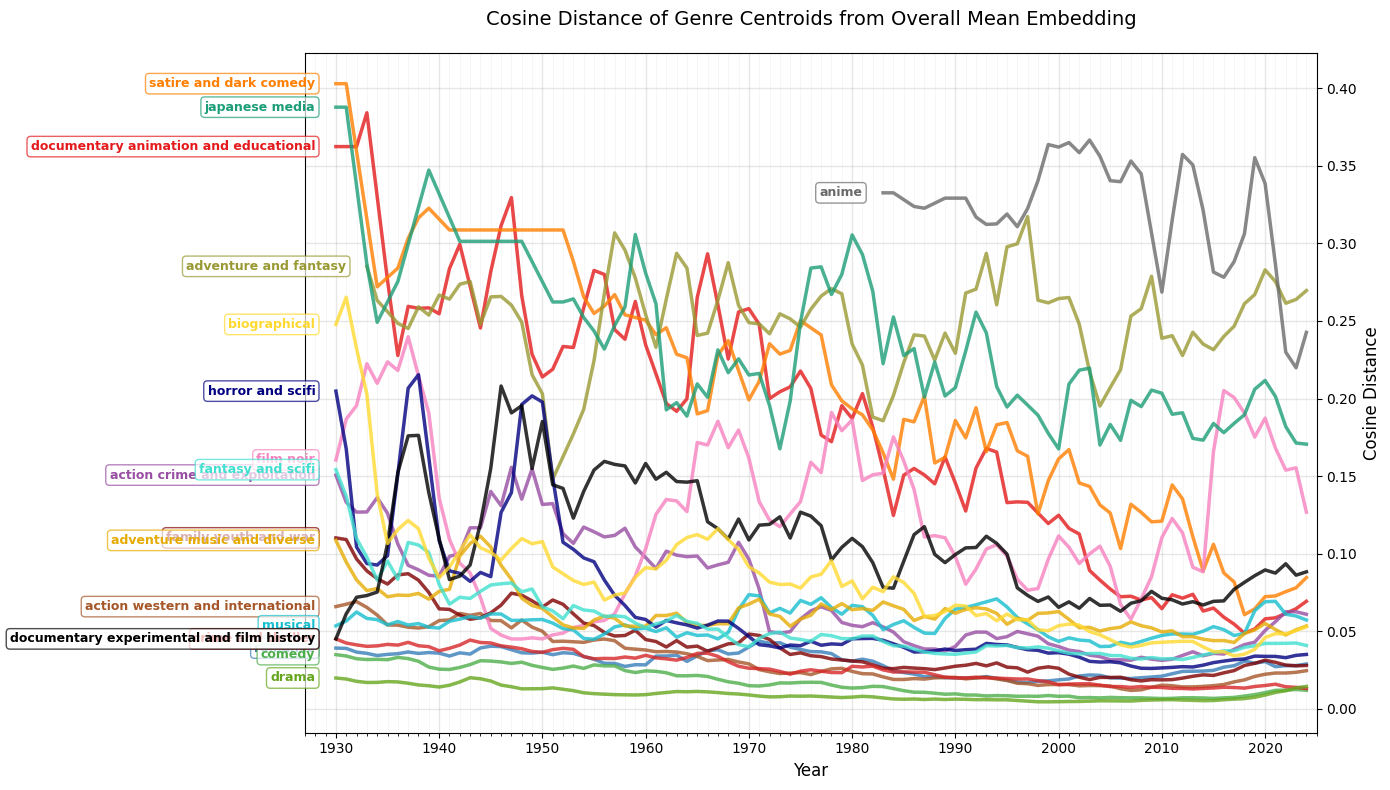

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

for i, (genre, distances) in enumerate(genre_evolution_results.items()):
    series = pd.Series(distances, index=years, dtype=float)
    series = series.ffill()
    
    if series.notna().sum() > 0:
        smoothed = series.rolling(window=3, center=True, min_periods=1).mean()
    else:
        smoothed = series
    
    color = genre_colours[i % len(genre_colours)]
    
    # Plot the line
    ax.plot(smoothed.index, smoothed.values, color=color, linewidth=2.5, alpha=0.8)
    
    # Add text label at the start
    first_valid_idx = smoothed.first_valid_index()
    if first_valid_idx is not None:
        first_y = smoothed[first_valid_idx]
        ax.text(first_valid_idx - 2, first_y, genre, 
               color=color, fontsize=9, fontweight='bold',
               va='center', ha='right',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                        edgecolor=color, alpha=0.7))

# Move y-axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.set_title("Cosine Distance of Genre Centroids from Overall Mean Embedding", 
             fontsize=14, pad=20)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Cosine Distance", fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.3)
ax.grid(which="minor", linewidth=0.5, alpha=0.15)
ax.set_xlim([1927, 2025])  # Extended left margin for labels
plt.tight_layout()
plt.show()